**Данные были предоставлены мне в рамках прохождения курса по продуктовой аналитике в Яндекс Практикуме - датасеты являются собственностью Яндекса, поэтому я не могу их выложить. Весь код написан мной.**

### Анализ данных проходит в рамках работы в интернет-магазине. 

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). **Нужно выявить определяющие успешность игры закономерности.** Это позволит сделать ставку на потенциально популярный продукт и **спланировать рекламные кампании**.<p>&nbsp;</p>
В датасете содержутся данные до 2016 года. **Нужно отработать кампанию на будущее, которая будет содержать в себе принцип работы с данными**. <p>&nbsp;</p>
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

#### В рамках исследовательского анализа данных нам предстоит найти ответы на следующие вопросы: 
- сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
- проанализировать, как менялись продажи по платформам. Надо выбрать платформы с наибольшими суммарными продажами и построить распределение по годам. Необходимо понять, за какой характерный срок появляются новые и исчезают старые платформы 
- определить **актуальный период** и взять данные за него. Основной фактор при выборе актуального периода — эти данные помогут построить прогноз на 2017 год
- необходимо выбрать, какие платформы лидируют по продажам, растут или падают? Нам надо определить несколько потенциально прибыльных платформ
- посмотреть, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков
- посмотреть на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?
---

#### Составить портрет пользователя каждого региона 
- для этого нам понадобится информация о самых популярных платформах 
- самых популярных жанрах
- а также ответить на вопрос о том, как влияет рейтинг ESRB на продажи в отдельном регионе
---
#### Проверить гипотезы: 
- средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- средние пользовательские рейтинги жанров Action и Sports разные.

In [1]:
# загрузим библиотеки и посмотрим на общую информацию о данных
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp 
from scipy import stats as st
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML('<style>.container{width:100%! important;}</style>'))

In [2]:
df = pd.read_csv('games.csv')
df.columns = map(str.lower, df.columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Обратим внимание, что в данных встречаются столбцы с неправильным типом данных: `year_of_release` - `float64`, `user_score` - 
`object`, `rating` - `object`

In [3]:
print("В датасете содержится", df['name'].nunique(), 'игр')
print('Период, когда выходили игры, представленные в датасете, с', int(df.year_of_release.min()),
      'до', int(df.year_of_release.max()))
print('В датасете представлено', df['genre'].nunique(), 'жанров для', df['platform'].nunique(), 'вида консолей')

В датасете содержится 11559 игр
Период, когда выходили игры, представленные в датасете, с 1980 до 2016
В датасете представлено 12 жанров для 31 вида консолей


### Сделаем предобработку данных: 

- посмотрим, есть ли в данных дубликаты
- обработаем пропуски
- приведем данные к нужным типам 
- разберемся с аббревиатуруй tbd (to be determined) в столбце rating
- посчитаем суммарные продажи

In [4]:
# посчитаем количество пропусков в каждой колонке
for  column in df.columns:
    print('Пропусков в столбце', column, ':', df[column].isna().sum())
print('Полных дубликатов в датафрейме:', df.duplicated().sum())
df['rating'].value_counts()

Пропусков в столбце name : 2
Пропусков в столбце platform : 0
Пропусков в столбце year_of_release : 269
Пропусков в столбце genre : 2
Пропусков в столбце na_sales : 0
Пропусков в столбце eu_sales : 0
Пропусков в столбце jp_sales : 0
Пропусков в столбце other_sales : 0
Пропусков в столбце critic_score : 8578
Пропусков в столбце user_score : 6701
Пропусков в столбце rating : 6766
Полных дубликатов в датафрейме: 0


E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

**В данных много пропусков.**  Они встречаются в столбцах `year_of_release`, `critic_score`, `user_score` и `rating`. Представляется, что пропуски в столбце с годами выпуска игр не имеет смысла заполнять никаким усредненным значением по столбцу, потому что год - независимая переменная. 

--- 

Вероятно, что данные с оценками по играм тоже не имеет смысла заполнять усредненными оценками. Это объясняется тем, что у нас слишком много пропусков, в каждом из трех столбцов их больше половины. 

In [5]:
# заполним пропуски нулями и изменим тип данных 
def fillna_and_convert_to_int(df, columns, value):
    df = df.copy()
    for col in columns:
        df[col] = df[col].fillna(value).astype(int)
    return df

# напишем такую же функцию, но с преобразованием в вещественные числа
def fillna_and_convert_to_float(df, columns, value):
    df = df.copy()
    for col in columns:
        df[col] = df[col].fillna(value).astype(float)
    return df
# у нас есть данные по продажам из некоторых стран и континентов. В дальнейшем для анализа нам понадобятся данные суммарных продаж
# напишем функцию, которая будет добавлять новые колонки в датафрейм 
def add_new_columns(df):
    df = df.copy()
    df['total_sales'] = df.reindex(['na_sales', 'jp_sales', 
                                    'eu_sales', 'other_sales'], 
                                  axis=1).sum(axis=1)
    return df

# заполним пропуски и добавим новую колонку
df = df.\
    pipe(fillna_and_convert_to_int, ['year_of_release'], 0).\
    pipe(fillna_and_convert_to_float, ['critic_score'], 0).\
    pipe(add_new_columns).\
    assign(user_score = lambda x: x['user_score'].replace('tbd', 0).fillna(0).astype(float),
          name = lambda x: x['name'].fillna('unknown'),
          genre = lambda x: x['genre'].fillna('unknown'),
          rating = lambda x: x['rating'].fillna('unknown'))

##### Посмотрим на количество игр выпущенных по годам, а также на выручку. Затем попытаемся найти актуальный для дальнейшего исследования период. 

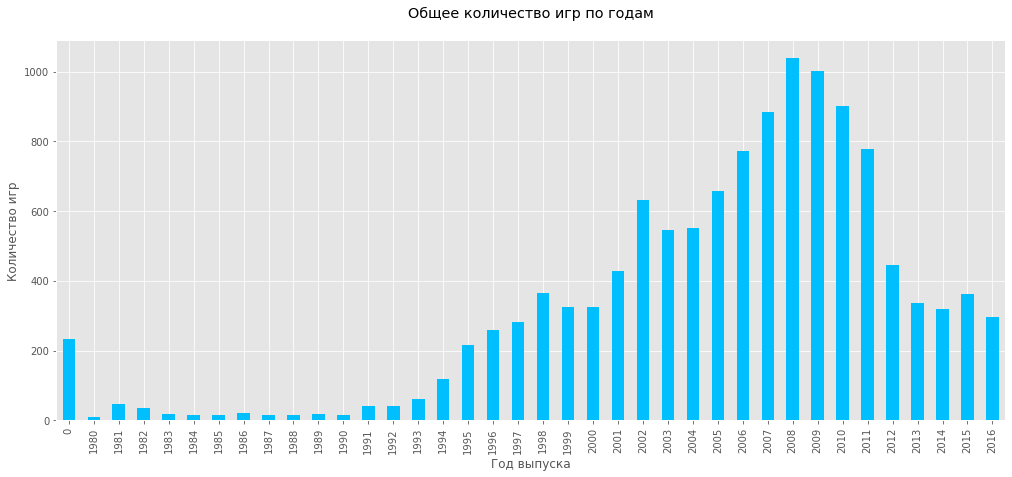

In [6]:
plt.style.use('ggplot')
df.groupby('year_of_release')['name'].nunique().plot(kind='bar', figsize=(17,7), grid=True, color='deepskyblue')
plt.ylabel('Количество игр')
plt.xlabel('Год выпуска')
plt.title('Общее количество игр по годам'+'\n')
plt.show()

По графику видно, что **выпуск игр, представленных в датасете, находился в 2015 году примерно на уровне 1998-1999**. При этом до 2001 года в датасете представлено значительно меньше игр (около 400 в год), чем в период с 2002 по 2011. **Пик выпуска игр**, содержащихся в датасете, **наблюдался в 2008-2009 годах**, когда выпускалось больше 1400 игр. **После этого количество игр в датасете пошло на убыль**. 
Таким образом, если принять предположение, что по нашей выборке можно судить о генеральной совокупности, можно сделать вывод, что производство игр в значительной степени увеличилось после 2001 года, но уменьшилось после 2011. 

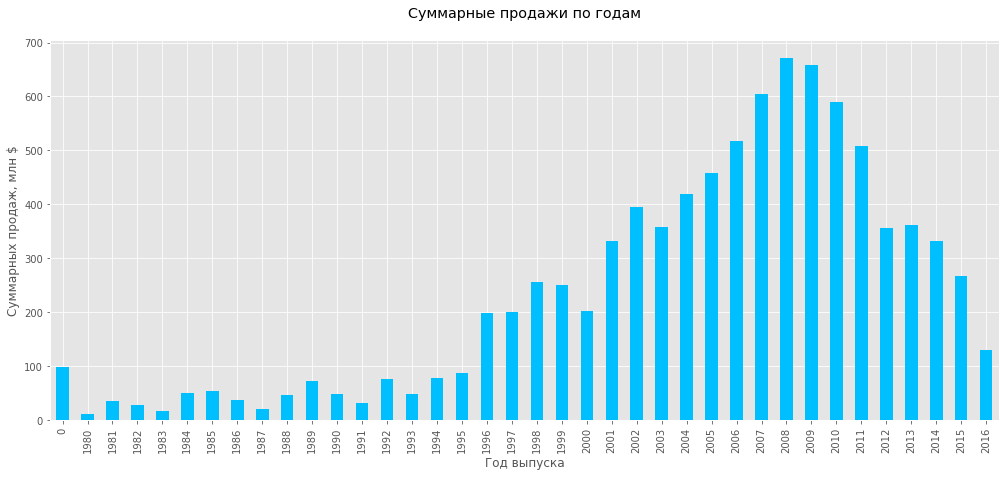

In [7]:
df.groupby('year_of_release')['total_sales'].sum().plot(kind = 'bar', figsize = (17,7), grid = True, color='deepskyblue')
plt.ylabel('Суммарных продаж, млн $')
plt.xlabel('Год выпуска')
plt.title('Суммарные продажи по годам'+'\n')
plt.show()

Видим схожую картину. **Пик по выручке приходится в период с 2005 по 2012 годы.** Наибольшая выручка от продаж получена в 2008 году - именно в этом году было выпущено больше всех игр. 

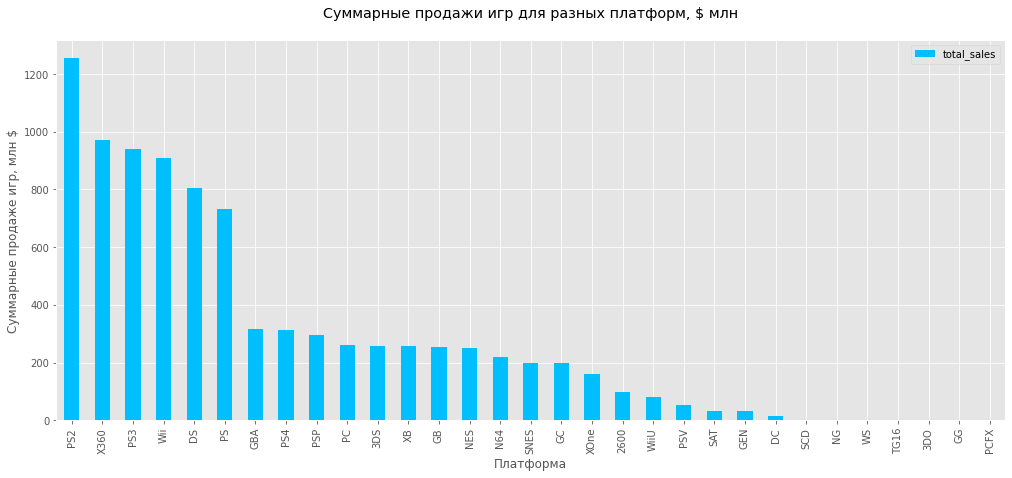

In [8]:
# теперь сгруппируем данные по платформам и посмотрим на выручку 
df.groupby('platform')['total_sales'].\
    sum().reset_index().\
    sort_values(by='total_sales', ascending = False).\
    reset_index(drop = True).\
    plot(x='platform', y='total_sales', kind='bar', figsize=(17,7), grid=True, color='deepskyblue')
plt.xlabel('Платформа')
plt.ylabel('Суммарные продаже игр, млн $')
plt.title('Суммарные продажи игр для разных платформ, $ млн'+'\n')
plt.show()

### Выводы: 
- **самой успешной платформой в нашей выборке стала PS2** с суммарными продажами игр более чем на миллиард долларов, PS 2 - единственная платформа, выручка по которой смогла перешагнуть за миллиард
- заметно, что на рынке в разное время существовали пять наиболее крупных консолей, две из них выпускает Sony (PS2, PS3), две - Nintendo (Wii, DS) и одну Microsoft - X360.
- видно, что **Япония - центр для мира видеоигр т.к. пять из шести консолей, которые входят в топ-5 по объему выручки, произведены японскими компаниями** (Microsoft - американская компания) 
---
Теперь попытаемся определить, **сколько длится жизненный цикл платформы**. Представляется, что репрезентацией такого показателя может стать **динамика изменения суммарной вырочки и количества выпущенных игр по годам, сгрупированной по платформам**. Построим такой график для первых шести платформ

In [9]:
# возьмем список из топ-5 платформ 
top_5_platforms = df.groupby('platform')['total_sales'].sum().reset_index().\
sort_values(by='total_sales', ascending=False).head(5)['platform'].\
to_list()
print(top_5_platforms) 

['PS2', 'X360', 'PS3', 'Wii', 'DS']


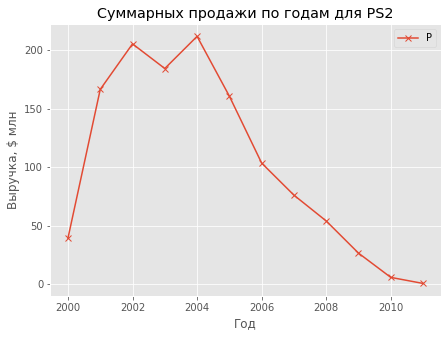

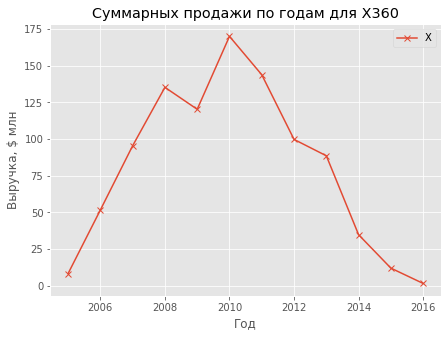

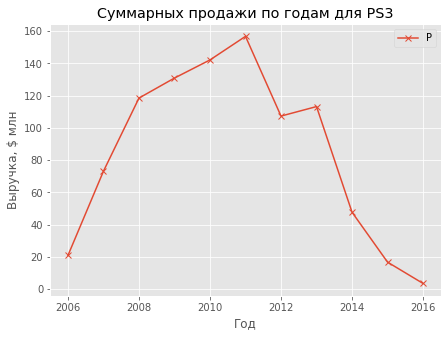

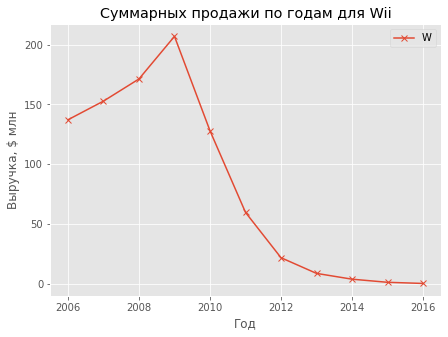

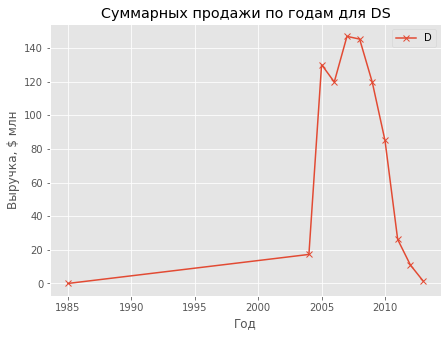

In [10]:
for i in top_5_platforms:
    df.query('platform == @i and year_of_release != 0').\
    pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(figsize=(7,5),
                                                                            style = '-x', grid=True, title='Суммарных продажи по годам для '+i)
    plt.ylabel('Выручка, $ млн')
    plt.xlabel('Год')
    plt.legend(i)
    plt.show()

### Выводы: 
- жизненный цикл платформы составляет в среднем 4-5 лет - период, когда консоль способна приносить максимальную выручку. 
- 4 - 6 лет - период, который в целом совпадает с периодом, за которые компании способны выпускать новые версии своих консолей. Например, PS вышла в 1994, PS2 в 2000, PS3 в 2006, PS4 в 2013. Подробнее можно посмотреть [тут](https://www.playstation.com/en-gb/explore/ps4/playstation-through-the-years/)

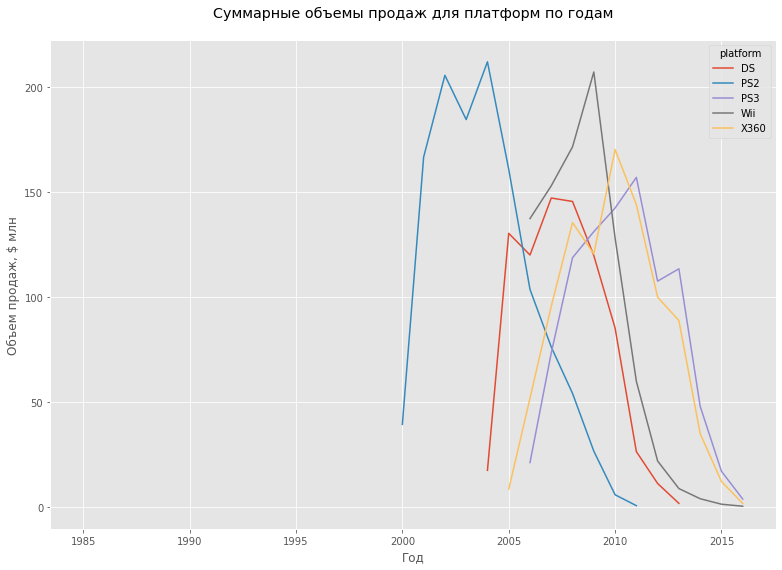

In [11]:
# теперь построим общий график для всех шести платформ
df.query('year_of_release != 0 and platform in @top_5_platforms').\
pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').\
plot(figsize=(13,9))
plt.title('Суммарные объемы продаж для платформ по годам'+'\n')
plt.ylabel('Объем продаж, $ млн')
plt.xlabel('Год')
plt.show()

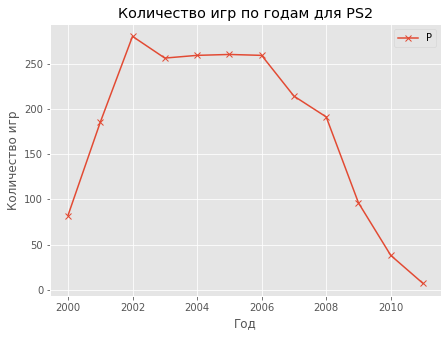

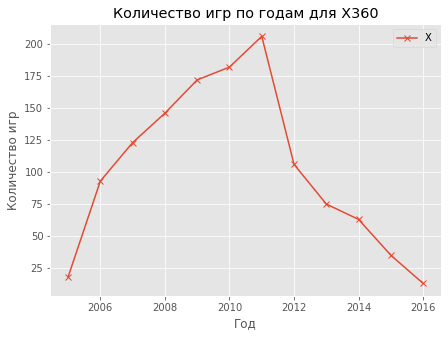

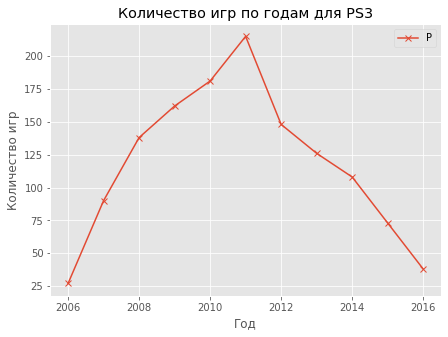

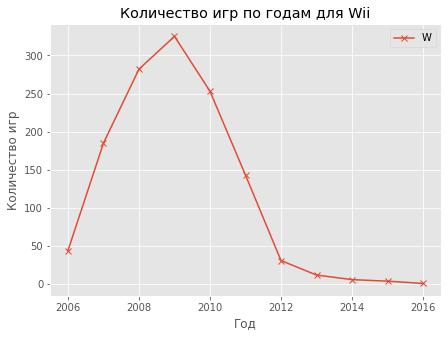

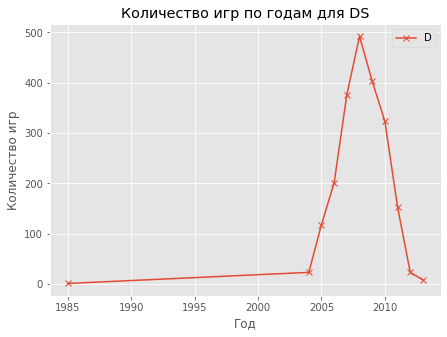

In [12]:
# посчитаем количество игр по платформам
for i in top_5_platforms:
    df.query('platform == @i and year_of_release != 0').\
    pivot_table(index='year_of_release', values='name', aggfunc='count').plot(figsize=(7,5),
                                                                            style = '-x', grid=True, title='Количество игр по годам для '+i)
    plt.ylabel('Количество игр')
    plt.xlabel('Год')
    plt.legend(i)
    plt.show()

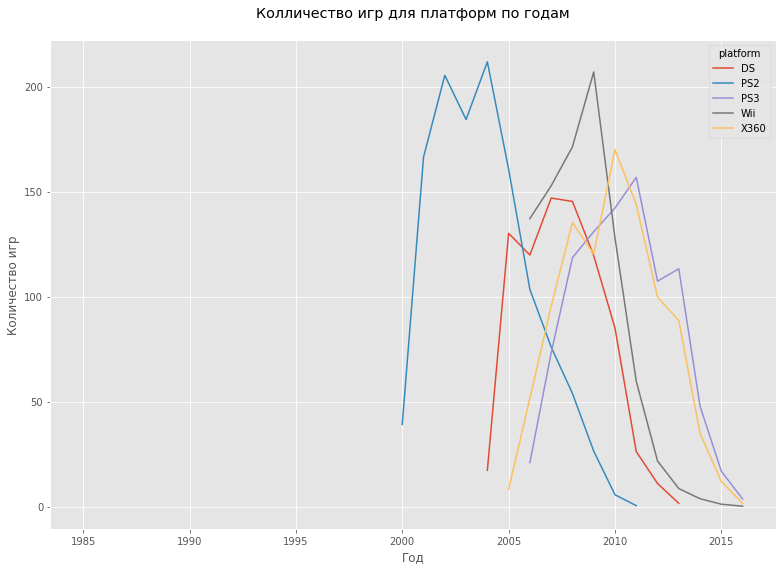

In [13]:
df.query('year_of_release != 0 and platform in @top_5_platforms').\
pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').\
plot(figsize=(13,9))
plt.title('Колличество игр для платформ по годам'+'\n')
plt.ylabel('Количество игр')
plt.xlabel('Год')
plt.show()

### Выводы:
- видим схожую картину, период, когда выпускается максимальное количество игр для консоли, составляет 4 - 6 лет. Возьмем среднее арифметическое между ними и наш получаем, что наш **актуальный для дальнейшего исследования период составляет 5 лет**
- нам надо сделать прогноз для 2017-го года, 2017-й год будет пятым в нашем ислледовании, поэтому возьмем данные за предыдущие четыре года. 

In [14]:
# сделаем срез с нужными данными 
df_5_years = df.query('year_of_release > (year_of_release.max() - 4)')

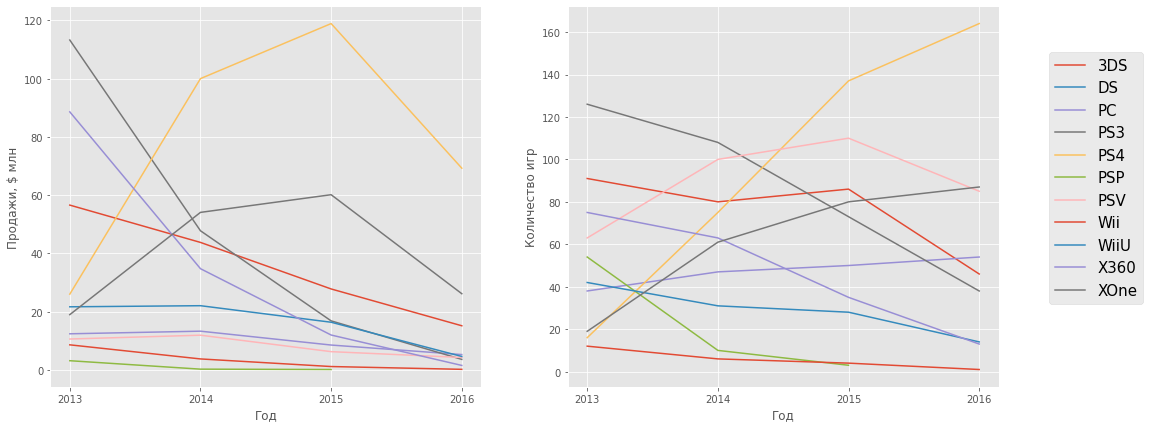

In [15]:
# посмотрим на выручку и количество игр по платформам по годам
four_years_sum = df_5_years\
.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc=['sum', 'count'])


plt.rcParams
fig, ax = plt.subplots(1,2)
fig.set_figwidth(17)
fig.set_figheight(7)

ax[0].plot(four_years_sum.index, four_years_sum['sum'])
ax[0].set_ylabel('Продажи, $ млн')
ax[0].set_xlabel('Год')
ax[0].xaxis.set_major_locator(plt.MaxNLocator(4))

ax[1].plot(four_years_sum.index, four_years_sum['count'])
ax[1].set_ylabel('Количество игр')
ax[1].set_xlabel('Год')
ax[1].xaxis.set_major_locator(plt.MaxNLocator(4))
plt.legend(four_years_sum.columns.droplevel(level=(0)), bbox_to_anchor=(1.1, 0.9),
          loc=2, prop={'size': 15})
plt.show()

#### Выводы: 
- глядя на первый график, можно заметить интересную тенденцию - **продажи по всем платформам падают.** Похоже, что пользователей забирают не у какой-то конкретной платформы, а у всего рынка консолей. Представляется, что **пользователи могут уходить к непрямым конкурентам, например, в мобильные игры.**
- глядя на второй график, можно заметить, что количество выпускаемых игр с 2015 по 2016 годы выросло только для XOne и PS4. 

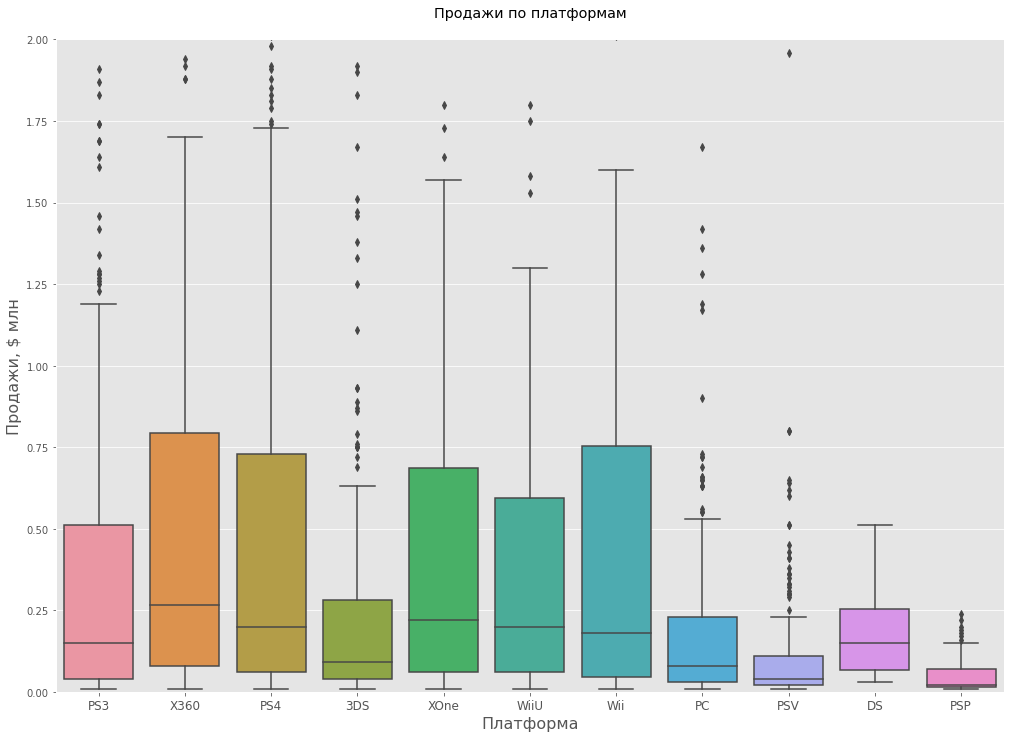

['PS4', 'PS3', 'XOne', '3DS', 'X360']

In [16]:
# посмотрим на продажи по платформам
plt.figure(figsize=(17,12))
sns.boxplot(y = df_5_years['total_sales'], x = df_5_years['platform'])
plt.ylim(0, 2)
plt.title('Продажи по платформам' + '\n')
plt.xlabel('Платформа', fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel('Продажи, $ млн', fontsize=16)
plt.show()



# необходимо выбрать, какие платформы лидируют по продажам, растут или падают? Нам надо определить несколько потенциально прибыльных платформ
# посмотрим на топ-5 платформ, которые лидируют по продажам 
recent_data_top_5_platforms = df_5_years.groupby('platform', as_index=False)['total_sales'].sum().\
reset_index().sort_values(by='total_sales', ascending=False).reset_index().head(5)['platform'].to_list()
recent_data_top_5_platforms

### Выводы:
- из данного графика видно, что у нас много выбросов. Это ожидаемая картина - одни игры более финансово успешны, другие - менее.
- около 50  % игр по платформам XOne и PS4 приносят в около 250 $ тыс. 

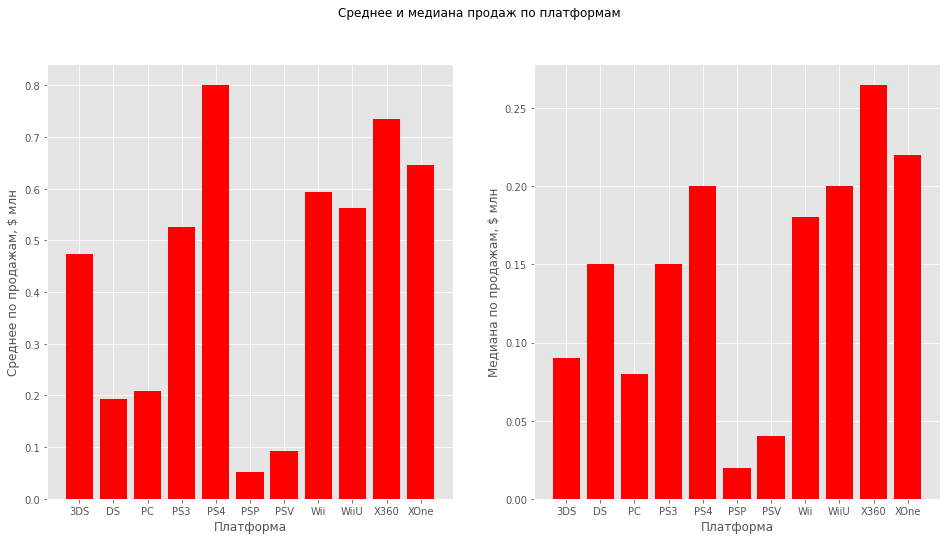

In [17]:
# посмотрим на разницу между средним и медианой общих продаж по платформам
numerical_outline = df_5_years.pivot_table(
                                            index='platform', values='total_sales', aggfunc=['mean', 'median'])
ylabels = ['Среднее по продажам, $ млн', 'Медиана по продажам, $ млн']

fig, ax = plt.subplots(1,2)
fig.set_figwidth(16)
fig.set_figheight(8)
fig.suptitle('Среднее и медиана продаж по платформам')
gr = 0

for column in numerical_outline.columns:
    ax[gr].bar(x=numerical_outline.index, height=numerical_outline[column], color='red')
    ax[gr].set_ylabel(ylabels[gr])
    ax[gr].set_xlabel('Платформа')
    gr +=1
plt.show()

### Выводы: 
- средние по продажам значительно выше, чем медианы. Это обуславливается тем, что в данных много выбросов. 
- **наиболее репрезентативная мера центральной тенденции в данном случае - медиана**

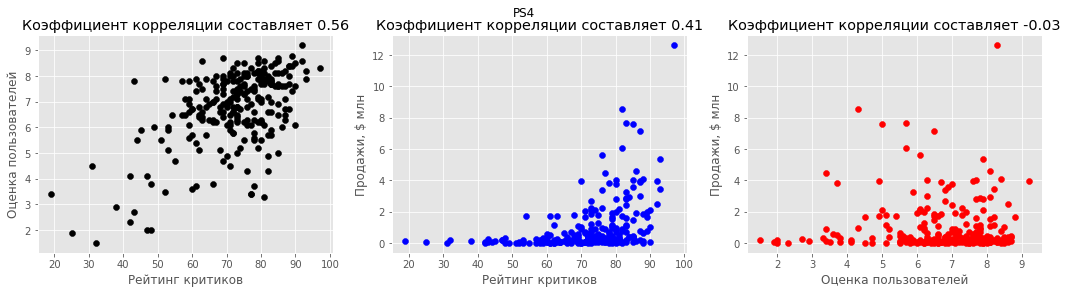

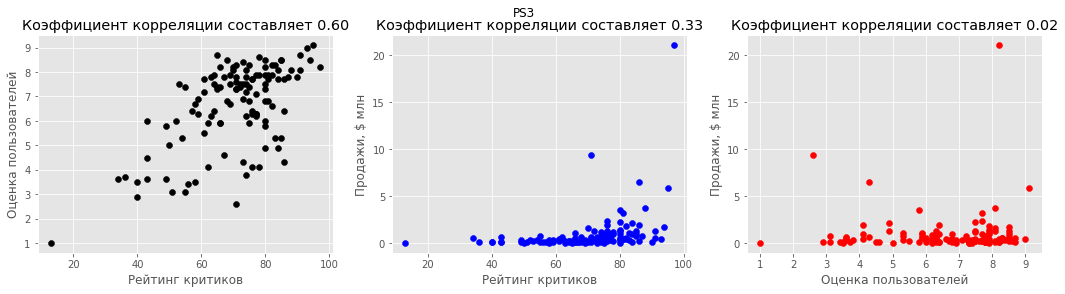

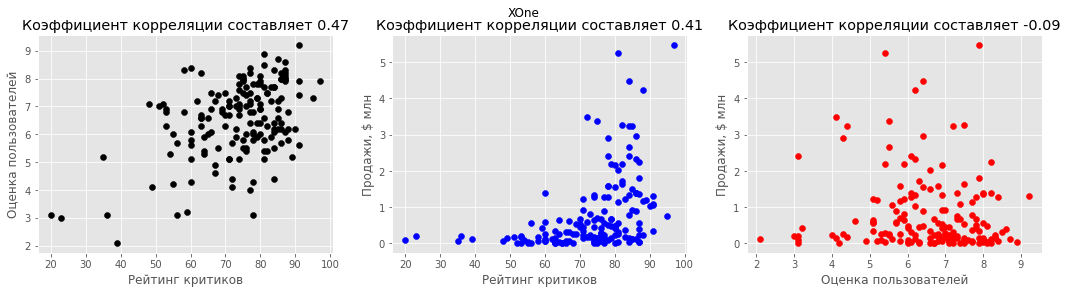

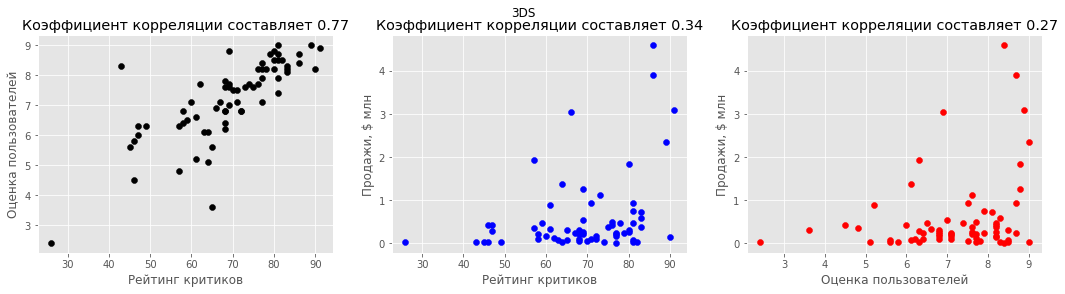

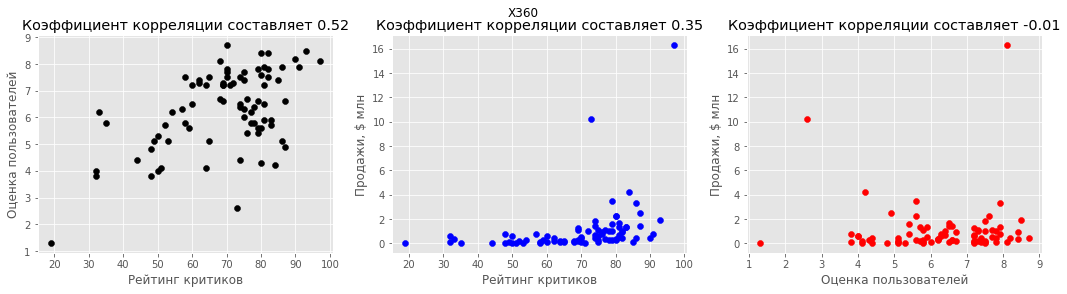

In [18]:
# посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков
# примим за популярную платформы те, которые лидируют по продажам и хранятся в переменной `platforms`
for platform in recent_data_top_5_platforms:
    platforms = df_5_years.query('platform == @platform and user_score != 0 \
    and critic_score != 0 and total_sales != 0')
    
    fig, ax = plt.subplots(1, 3)
    fig.suptitle(platform + '\n')
    fig.set_figwidth(18)
    
    ax[0].scatter(x=platforms['critic_score'], y=platforms['user_score'], color='black')
    ax[0].set_xlabel('Рейтинг критиков', fontsize=12)
    ax[0].set_ylabel('Оценка пользователей', fontsize=12)
    ax[0].set_title('Коэффициент корреляции составляет {:.2f}'.format(platforms['user_score'].\
                                    corr(platforms['critic_score'], method='pearson')))
    
    ax[1].scatter(x=platforms['critic_score'], y=platforms['total_sales'], color='blue')
    ax[1].set_xlabel('Рейтинг критиков')
    ax[1].set_ylabel('Продажи, $ млн')
    ax[1].set_title('Коэффициент корреляции составляет {:.2f}'.format(platforms['critic_score'].\
                                                                     corr(platforms['total_sales'], method='pearson')))
    
    ax[2].scatter(x=platforms['user_score'], y=platforms['total_sales'], color='red')
    ax[2].set_xlabel('Оценка пользователей')
    ax[2].set_ylabel('Продажи, $ млн')
    ax[2].set_title('Коэффициент корреляции составляет {:.2f}'.format(platforms['user_score'].\
                                                                     corr(platforms['total_sales'], method='pearson')))
    
    plt.show()

### Выводы: 
- есть умеренная (PS4, PS3, XOne, X360) и временами сильная корреляция (3DS) между оценками критиков и пользователей.
- умеренная корреляция между рейтингом критиков и продажам 
- между оценками пользователей и продажами корреляции нет. 

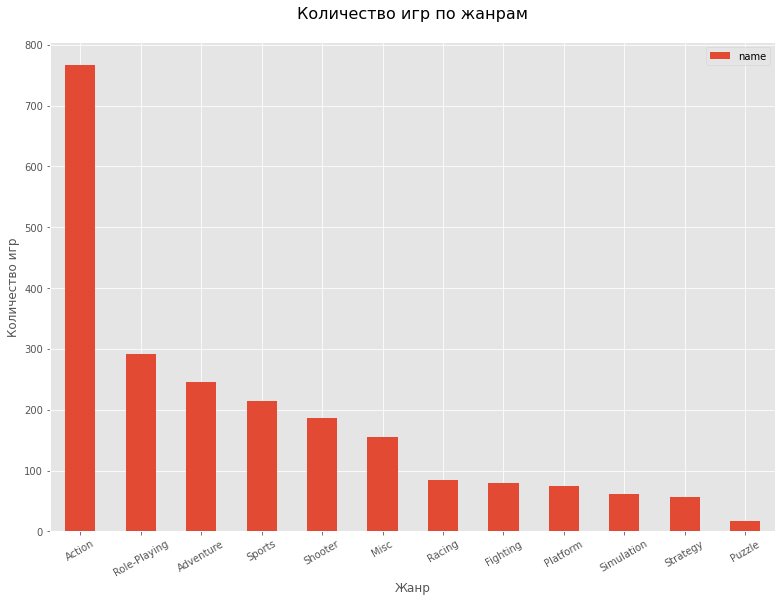

Процентное соотношение по жанрам:


Action          0.34
Role-Playing    0.13
Adventure       0.11
Sports          0.10
Shooter         0.08
Misc            0.07
Racing          0.04
Fighting        0.04
Platform        0.03
Simulation      0.03
Strategy        0.03
Puzzle          0.01
Name: genre, dtype: float64

In [19]:
# посмотрим, как распределились игры по жанрам
numerical_outline_genres = df_5_years.pivot_table(index='genre', values='name', aggfunc='count').\
sort_values(by='name', ascending=False).plot(figsize=(13,9), kind='bar')
plt.title('Количество игр по жанрам' + '\n', fontsize=16)
plt.ylabel('Количество игр', fontsize=12)
plt.xlabel('Жанр', fontsize=12)
plt.xticks(rotation=30, fontsize=10)
plt.show()

print('Процентное соотношение по жанрам:') 
display(df_5_years['genre'].value_counts(normalize=True).sort_values(ascending=False).round(2))

#### Выводы: 
- видим, что **34 % всех игр приходится на жанр action**. От 8% до 13% имеют жанры: Role-Playing, Adventure, Sports, Shooter

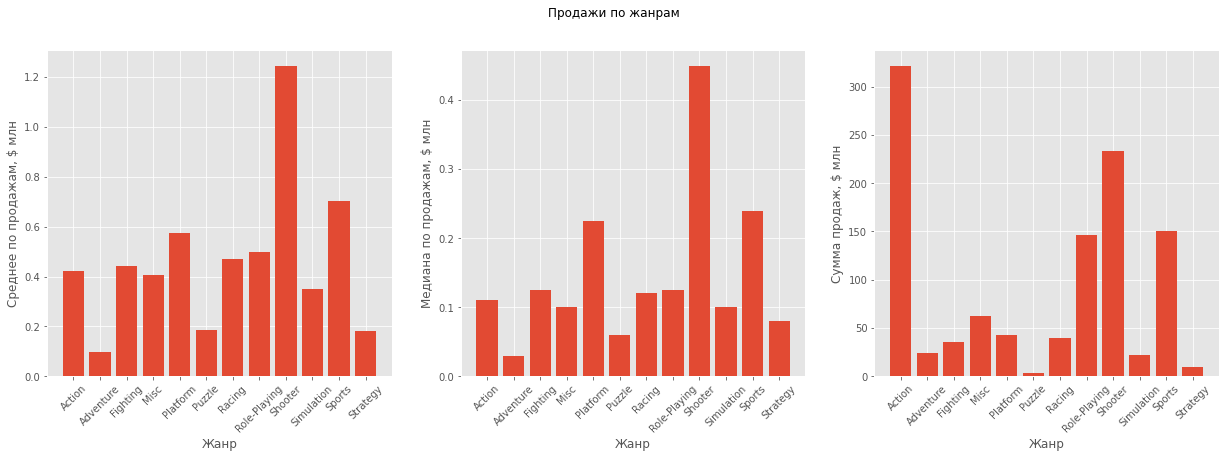

In [20]:
# теперь посмотрим на продажи по жанрам 
numerical_outline_genres = df_5_years.pivot_table(
                                                    index='genre', values='total_sales', aggfunc=['mean', 'median', 'sum'])

ylabels = ['Среднее по продажам, $ млн', 'Медиана по продажам, $ млн', 'Сумма продаж, $ млн']
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(6)
fig.suptitle('Продажи по жанрам')
gr = 0

for column in numerical_outline_genres.columns:
    ax[gr].bar(x=numerical_outline_genres.index, height=numerical_outline_genres[column])
    ax[gr].set_ylabel(ylabels[gr])
    ax[gr].set_xlabel('Жанр')
    ax[gr].tick_params(axis='x', labelrotation=45)
    gr +=1
    
plt.show()

### Выводы: 
- нашему магазину точно стоит присмотреться внимательно к жанру shooter, игр в нем выходит мало (8 % от всех игр), но средняя выручка, полученная с одной игры, составляет более 1.2  $ млн - пракически в два раза больше, чем у ближайшего конкурента. По суммарным продажам этот жанр второй.
- самая высокая суммарная выручка у жанра Action - более 300 млн. 
- Action, Role-playing, Shooter, Sport - лидируют по показателю общих продаж. 

### Построим портрет пользователя. Для этого проанализируем: 
- какие платформы и жанры наиболее популярны в Северной Америке, Европе, Японии
- какого возраста основная аудитория в этих континентах и странах (посмотрим на рейтинг ESRB)

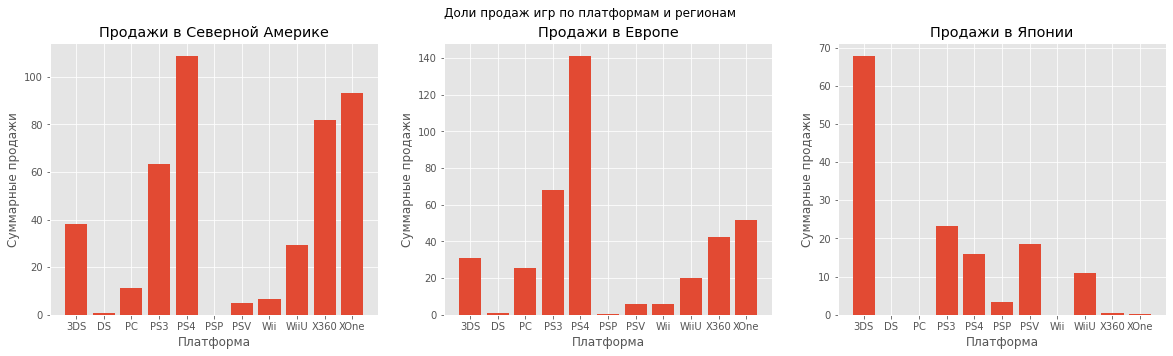

In [21]:
# построим портрет пользователя
# для начала проанализируем, какие консоли наиболее популярны в разных географических локациях
graph_titles = ['Продажи в Северной Америке', 'Продажи в Европе', 'Продажи в Японии']
gr = 0
fig, ax = plt.subplots(1,3, figsize=(20, 5))
plt.suptitle('Доли продаж игр по платформам и регионам')

for column in ['na_sales', 'eu_sales', 'jp_sales']:
    geo_outline = df_5_years.pivot_table(index='platform',
                                         values=column,
                                         aggfunc='sum')
    #geo_outline.columns = ['platform', 'total_sales']
    ax[gr].bar(geo_outline.index, height=geo_outline[column])
    ax[gr].set_ylabel('Суммарные продажи')
    ax[gr].set_xlabel('Платформа')
    ax[gr].set_title(graph_titles[gr])
    gr +=1
plt.show()

### Выводы:
Самые популярные платформы: 
- в Северной Америке - PS4, PS3, X360, XOne
- в Европе - PS4 с большим отрывом от всех
- в Японии - 3DS с большим отрывом от всех

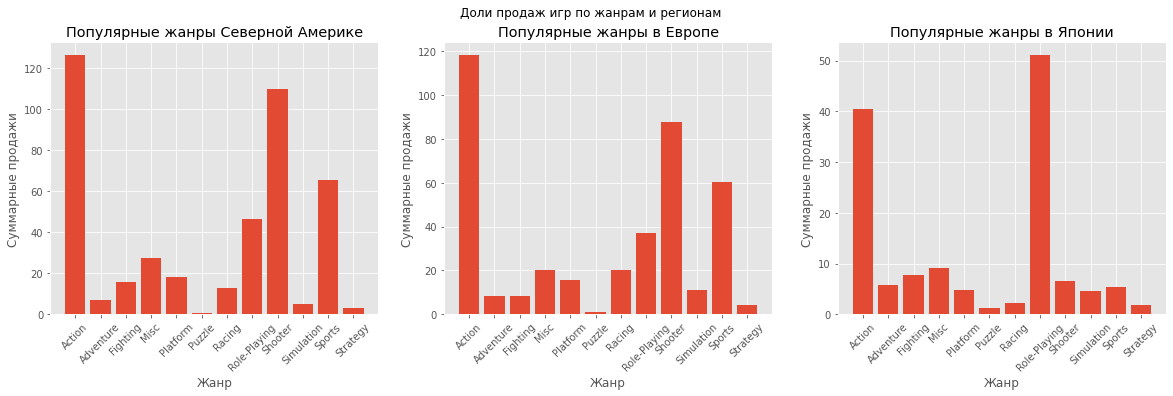

In [22]:
graph_titles = ['Популярные жанры Северной Америке', 'Популярные жанры в Европе', 'Популярные жанры в Японии']
gr = 0
fig, ax = plt.subplots(1,3, figsize=(20, 5))
plt.suptitle('Доли продаж игр по жанрам и регионам')

for column in ['na_sales', 'eu_sales', 'jp_sales']:
    geo_outline = df_5_years.pivot_table(index='genre',
                                         values=column,
                                         aggfunc='sum')
    #geo_outline.columns = ['platform', 'total_sales']
    ax[gr].bar(geo_outline.index, height=geo_outline[column])
    ax[gr].set_title(graph_titles[gr])
    ax[gr].set_ylabel('Суммарные продажи')
    ax[gr].set_xlabel('Жанр')
    ax[gr].set_title(graph_titles[gr])
    ax[gr].tick_params(axis='x', labelrotation=45)
    gr +=1
plt.show()

### Выводы: 
- в Европе и Северной Америке самые популярные жанры - Action, Shooter, Sports
- в Японии - Role-playing, Action

unknown    6766
E          3990
T          2961
M          1563
E10+       1420
EC            8
K-A           3
RP            3
AO            1
Name: rating, dtype: int64

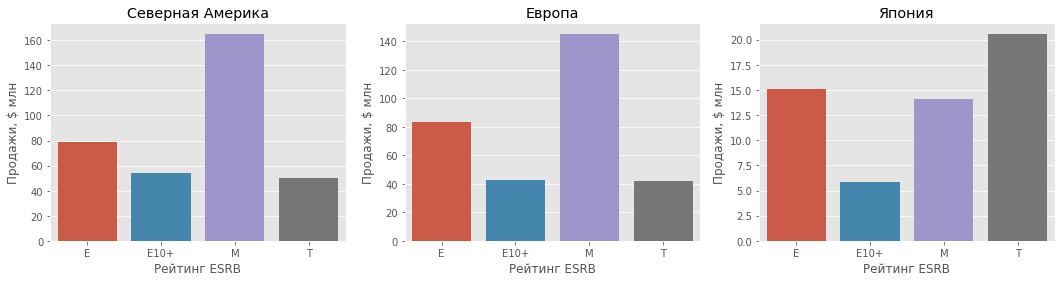

In [23]:
# теперь посмотрим на рейтинг ESRB по географическому признаку
titles=['Северная Америка', 'Европа', 'Япония']
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
gr = 0

for column in ['na_sales', 'eu_sales', 'jp_sales']:
    outline_rating = df_5_years.pivot_table(index='rating', values=column, aggfunc='sum')
    outline_rating = outline_rating.query('rating != "unknown"')
    sns.barplot(x=outline_rating.index, y=outline_rating[column], ax=ax[gr])
    ax[gr].set_title(titles[gr])
    ax[gr].set_xlabel('Рейтинг ESRB')
    ax[gr].set_ylabel('Продажи, $ млн')
    gr +=1

# обратим внимание, что визуализировать рейтинг не имеет смысла по категориям, где количество игр меньше 10 - у нас таких категорий четыре
df.rating.value_counts()

### Выводы: 
- рынок консолей в Европе и Северной Америке в первую очередь ориентирован на категорию M (mature, 17+). И это отлично логически укладывается с тем, что наиболее популярные жанры - Action, Shooter, Sports
- значительную долю рынка в Европе и Северной Америка занимает возрастная категория E (early, 10+). Вероятно, что для этой категории основными жанрами являются Sport, Role-playing и некоторые игры из жанра Action.
- в Японии есть три примерно одинаковых по размеру группы аудитории. Это e (early, 10+), m (mature, 17+) и t (teen, 13+). Среди этих групп наиболее популярные жанры - Role-playing и Action. Это тоже выглядит вполне логично. 

### Проверка гипотез. 

У нас есть две гипотезы, которые надо проверить: 
- *средние пользовательские рейтинги платформ Xbox One и PC одинаковые*
- *средние пользовательские рейтинги жанров Action и Sports разные*

Алгоритм действий:

- найдемем нужные для тестирований материалы в датафрейме df_5_years 
- посмотрим на распределения тестируемых переменных
- напишем функцию, которая будет проверять наше распределение на нормальность
- если распределение нормальное, применим t критерий Стъюдента 
- если распределение отличается от нормального, то проведем непараметрический тест Манна-Уитни

In [24]:
user_score_xone = df_5_years.query('platform == "XOne" and user_score != 0')['user_score'].dropna()
user_score_xone.name = 'Пользовательские оценки для Xbox One'
user_score_pc = df_5_years.query('platform == "PC" and user_score != 0')['user_score'].dropna()
user_score_pc.name = 'Пользовательские оценки для PC'
user_score_action = df_5_years.query('genre == "Action" and user_score != 0')['user_score'].dropna()
user_score_action.name = 'Пользовательские оценки для жанра Action'
user_score_sport = df_5_years.query('genre == "Sports" and user_score != 0')['user_score'].dropna()
user_score_sport.name = 'Пользовательские оценки для жанра Sport'

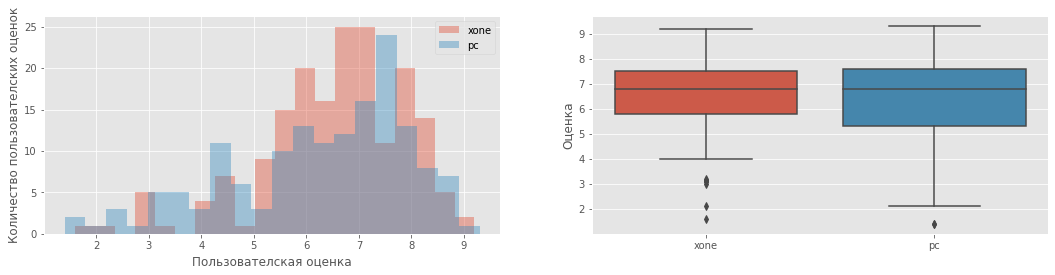

In [25]:
user_score_platforms = pd.concat([user_score_xone, user_score_pc], axis=1)
user_score_platforms.columns = ['xone', 'pc']

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(18)

sns.distplot(user_score_platforms['xone'], bins=20, label='xone', kde=False, ax=ax[0])
sns.distplot(user_score_platforms['pc'], label='pc',  bins=20, kde=False, ax=ax[0])
ax[0].set_ylabel('Количество пользователских оценок')
ax[0].set_xlabel('Пользователская оценка')
ax[0].legend()

sns.boxplot(data=user_score_platforms, ax=ax[1])
ax[1].set_ylabel('Оценка')
plt.show()

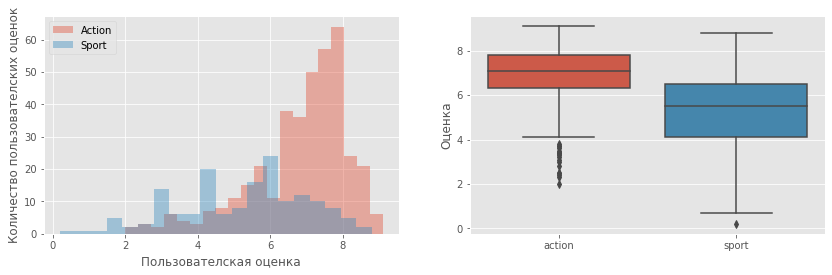

In [26]:
user_score_genres = pd.concat([user_score_action, user_score_sport], axis=1)
user_score_genres.columns = ['action', 'sport']

fig, ax = plt.subplots(1,2)
fig.set_figwidth(14)
sns.distplot(user_score_action, kde=False, bins=20, label='Action', ax=ax[0])
sns.distplot(user_score_sport, kde=False, bins=20, label='Sport', ax=ax[0])
ax[0].set_ylabel('Количество пользователских оценок')
ax[0].set_xlabel('Пользователская оценка')
ax[0].legend()


sns.boxplot(data=user_score_genres, ax=ax[1])
ax[1].set_ylabel('Оценка')
plt.show()

In [27]:
# напишем функцию для проверки распределения на нормальность
def normality_check(column, alpha):
    result = st.shapiro(column)
    print('p-значение составляет', result[1])
    if result[1] < alpha:
        print('Распределение отличается от нормального')
    else:
        print('Распределение нормальное')

In [28]:
# функция для t критерия Стъюдента, которую будем применять для проверки гипотезы о равенстве двух средних для независимых выборок, если распределение нормальное 
def ttest(column_1, column_2, alpha):
    result = st.ttest_ind(column_1, column_2)
    print(column_1.name, column_1.mean())
    print(column_2.name, column_2.mean())
    print('p-значение составляет', result[1])
    if result[1] < alpha:
        print('Отвергаем нулевую гипотезу - средние двух независимых выборок не равны')
    else:
        print('Не смогли отвергнуть нулевую гипотезу -\
        различие средних двух независимых выборок не имеет статистической значимости')

In [29]:
# напишем функцию для проведения непараметрического теста Манна-Уитни, если распределение отличается от нормального 
def mann_whitneyu_test(column_1, column_2, alpha):
    result = st.mannwhitneyu(column_1, column_2)
    print(column_1.name, column_1.mean())
    print(column_2.name, column_2.mean())
    print('p-значение составляет', result[1])
    if result[1] < alpha:
        print('Отвергаем нулевую гипотезу - средние двух независимых выборок не равны')
    else:
        print('Не смогли отвергнуть нулевую гипотезу - различие средних двух независимых выборок не имеет статистической значимости')

In [30]:
for column in [user_score_xone, user_score_pc, user_score_action, user_score_sport]:
    print(column.name)
    normality_check(column, 0.05)
    print(' ')

Пользовательские оценки для Xbox One
p-значение составляет 1.524856543255737e-05
Распределение отличается от нормального
 
Пользовательские оценки для PC
p-значение составляет 5.039790721639292e-06
Распределение отличается от нормального
 
Пользовательские оценки для жанра Action
p-значение составляет 1.0798927229597587e-14
Распределение отличается от нормального
 
Пользовательские оценки для жанра Sport
p-значение составляет 0.03234051540493965
Распределение отличается от нормального
 


In [31]:
mann_whitneyu_test(user_score_xone, user_score_pc, .05)

Пользовательские оценки для Xbox One 6.521428571428572
Пользовательские оценки для PC 6.2696774193548395
p-значение составляет 0.2505503367311187
Не смогли отвергнуть нулевую гипотезу - различие средних двух независимых выборок не имеет статистической значимости


In [32]:
mann_whitneyu_test(user_score_action, user_score_sport, .05)

Пользовательские оценки для жанра Action 6.837532133676092
Пользовательские оценки для жанра Sport 5.238124999999999
p-значение составляет 7.594585292409964e-24
Отвергаем нулевую гипотезу - средние двух независимых выборок не равны


По результатам проверки гипотез получили:
- **Различие средней пользовательской оценки для PC и XOne не имеет статистической значимости**
- **Средние оценки пользователей в жанрах Action и Sport не равны** 

Перед написанием общих выводов надо сделать оговорку, что данного исследования не достаточно для составления полной рекомендации для магазина.

Очень многое зависит от того, из какого региона у нас большинство покупателей, поэтому перед тем как решать, какие игры покупать на следующий год, надо провести анализ клиентской базы за предыдущие годы.  

---

### Итоговые выводы и рекомендации магазину:

#### **Исследовательский анализ данных**
 **Cколько игр выпускалось в разные годы. Важны ли данные за все периоды?**
-  *наибольшее количество игр выпускалось в промежутке между 2005 и 2011 годами. В эти годы выпускалось около 1000 игр в год. Сейчас на рынке произошел спад и количество игр, выпускаемых в год, за последние два года составляет 300-400. Также заметен общий тренд и в спаде продаж. Это может объясняться тем, что рынок видеоигр теряет клиентов, которые уходят к непрямым конкурента. Например, клиентов, которые меняют консоль на мобильные игры. Возможно, сказалось то, что после 2013 года начинает активно развиваться киберспорт (например в 2013 году [League of Legends](https://ru.wikipedia.org/wiki/League_of_Legends) признали видом спорта в США) В ходе исследования мы выяснили, что жизненный цикл платформы составляет в среднем 5 лет, поэтому для анализа были взяты данные за четыре предыдщих года (пятый год - 2017)* 

---

**Проанализировать, как менялись продажи по платформам. Надо выбрать платформы с наибольшими суммарными продажами и построить распределение по годам. Необходимо понять, за какой характерный срок появляются новые и исчезают старые платформы:**

- *начиная с 2013 года и объем продаж и объем выпускаемых игр падал для всех платформ, кроме XOne и PS4. Данные платформы росли с 2013 до 2015 и падали, начиная с 2015. В процессе исследования мы выяснили, что период, когда платформа способна приносить наибольшие продажи составляет 5 лет.*

---

**Необходимо выбрать, какие платформы лидируют по продажам, растут или падают? Нам надо определить несколько потенциально прибыльных платформ**

- *самые потенциально прибыльные для нас платформы - это XOne, PC и PS4. Количество выпускаемых игр для них стабильно растет, а соответственно они находятся в активной фазе своего жизненного цикла* 

---

**Посмотреть, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков**

- *продажи игр вообще не коррелируют с оценками пользователей, но умеренно коррелируют с рейтингом критиков (r составляет от 0.33 до 0.41)*

---

**Посмотреть на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?**

- *самые популярные жанры - Action, Shooter, Sports, в Японии это также Role-Playing*
- *не самый часто представленный жанр shooter является одним из самых потенциально выгодных. Он представлен всего в 7.9% игр, но на него приходится второй показатель продаж в 128.2 $ млн.*


#### Портрет пользователя 

- **Япония**: *жанры: Action, Role-Playing, консоли: 3DS, PC3, PSV, рейтинги ESRB: M(17+), T(13+), E(10+) 
- **Северная Америка**: *жанры: Action, Shooter, Sports, консоли: PS3, PS4, X360, XOne , рейтинги ESRB:  M(17+), E(10+)*
- **Европа**: *жанры:Action, Shooter, Sports, консоли: PS3, PS4, рейтинги ESRB: M(17+), E(10+)*

#### Проверка гипотез 
- *Cредний пользовательский рейтинг XOne не равен среднему пользовательскому рейтингу PC*
- *Не смогли отвергнуть нулевую гипотезу о том, что средний пользовательский рейтинг жанра Action равен среднему пользовательскому рейтингу жанра Sports*